<a href="https://colab.research.google.com/github/Shopping-Yuan/ML_Project/blob/Shopping_vscode_branch/CNN_Classification/CNN_Classification_fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get Data

In [1]:
!sudo apt install megatools
!megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"
# Unzip the dataset.
# This may take some time.
!unzip -q /content/food-11.zip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
megatools is already the newest version (1.10.3-1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.

ERROR: Download failed for 'https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg': Can't rename donwloaded temporary file /content/.megatmp.zt1TTIhK to /content/food-11.zip (downloaded data are good!): Error moving file /content/.megatmp.zt1TTIhK: File exists
replace food-11/training/unlabeled/00/5176.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


###Prepare Dataset

In [2]:
from torchvision.transforms import v2
from torchvision.datasets import DatasetFolder
from torch.utils.data import ConcatDataset
from PIL import Image
def get_tfm(data_info):
    tfm = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(data_info["size"]),
    ])
    return tfm
def get_tfm_flip(data_info):
    tfm_flip = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(data_info["size"]),
    v2.RandomHorizontalFlip(p=1),
    ])
    return tfm_flip
def food_f(mode,data_info):
    dataset = DatasetFolder(data_info[mode]["path"], \
          loader=lambda x: Image.open(x), \
          extensions="jpg", transform=get_tfm(data_info))
    if mode in ["train_origin"]:
      dataset_flip = DatasetFolder(data_info[mode]["path"], \
          loader=lambda x: Image.open(x), \
          extensions="jpg", transform=get_tfm_flip(data_info))
      dataset = ConcatDataset([dataset,dataset_flip])
    print('Size of {} data: {}'.format(mode,len(list(dataset))))
    return dataset

# This part is for semi- supervised learning
class Label_Changable_dsf(DatasetFolder):
    def __init__(self,root,loader,extensions,transform):
            super().__init__(root, loader, extensions , transform,)
    def change_targets(self ,correct_target):
      for i , t in enumerate(correct_target):
        self.targets[i] = t

def food_semi_f(mode,data_info,DatasetFolder):
    dataset = DatasetFolder(data_info[mode]["path"], \
          loader=lambda x: Image.open(x), \
          extensions="jpg", transform=get_tfm(data_info))

    print('Size of data for semi-supervised-learning: {}'.format(len(list(dataset))))
    return dataset

In [3]:
from torch import nn
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 32, 32]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(4, 4, 0),
        )
        self.flat_layer = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(int(256 * data_info["size"][0]/16 * data_info["size"][1]/16), 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 11)
        )
        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = self.flat_layer(x)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x
    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

### Semi-supervised learning

In [15]:
from torch.utils.data import ConcatDataset , Subset
def get_pseudo_labels(model, training_loader ,h_paras):

    softmax = nn.Softmax(dim=-1)
    model.eval()
    # Construct a data loader.
    semi_datasetfolder = food_semi_f("train",data_info,Label_Changable_dsf)
    semi_dataset_loader = \
    DataLoader(semi_datasetfolder, \
               batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)


    correct_label = []
    correct_index = []

    for batch_num , batch in enumerate(tqdm(semi_dataset_loader,desc = "get new training set")):
        img = batch[0]


        with torch.no_grad():
            img_d = img.to(device)
            prep = model(img_d)
        predicts = softmax(prep)
        max_prob , max_column_index = predicts.max(dim = -1)

        max_prob_list = max_prob.tolist()
        max_column_index_list = max_column_index.tolist()
        correct_label += [max_column_index_list[i]  \
                          for i in range(len(max_column_index_list)) if max_prob_list[i] > h_paras["threshold"]]
        correct_index += [(i + batch_num * h_paras["batch_size"]) \
                          for i in range(len(max_column_index_list)) if max_prob_list[i] > h_paras["threshold"]]

    if len(correct_index)>0:
      semi_datasetfolder.change_targets(correct_label)
      add_train_set = Subset(semi_datasetfolder,correct_index)

      new_train_set = ConcatDataset([food_f("train_origin",data_info),add_train_set])
      training_loader = DataLoader(new_train_set, batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)


      #build a dic to print the number of label of each class added to add_train_set
      label_dict = {}
      label_set = set(correct_label)
      for i in label_set:
        label_dict[i] = correct_label.count(i)
      print("add total {} datas to training dataset, each label numbers as follow {}".format(len(correct_index),label_dict))

    return training_loader

### Training & Validation & Inference

In [16]:
def train(train_loader,model_d,optimizer,device):
    # set model to training mode
    model_d.train()
    total_correct_number = 0
    train_loss_list = []
#    print(type(train_loader))
    # iterate through the dataloader
    for data , label in tqdm(train_loader, desc = "training"):
      # move data to device (cpu/cuda)
      data_d , label_d = data.to(device), label.to(device)
      # forward pass (compute output tensor)
      pred = (model_d(data_d))
      # get the index of the class with the highest probability
      max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
      correct_number = (max_prob_indexs.cpu() == label_d.cpu()).sum().item()
#      print(correct_number)
      total_correct_number += correct_number
      # compute loss
      loss = model_d.cal_loss(pred , label_d)
      # compute gradient (backpropagation)
      loss.backward()
      # Clip the gradient norms for stable training.
      nn.utils.clip_grad_norm_(model_d.parameters(), max_norm=10)
      # update model with optimizer
      optimizer.step()
      # set optimizer gradient to zero
      optimizer.zero_grad()
      train_loss_list.append(loss.detach().cpu().item())
    acc = total_correct_number/len(train_loader.dataset)
#    print(acc , train_loss_list)
    return acc , train_loss_list

In [17]:
def val(val_loader,model_d,device):
    # set model to evalutation mode
    model_d.eval()
    total_correct_number = 0
    total_loss = 0
    # iterate through the dataloader
    for data , label in tqdm(val_loader, desc = "validation"):
    # move data to device (cpu/cuda)
      data_d, label_d = data.to(device), label.to(device)
      # disable gradient calculation
      with torch.no_grad():
        # forward pass (compute output)
        pred = model_d(data_d)
        # get the index of the class with the highest probability
        max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
        total_correct_number += (max_prob_indexs.cpu() == label_d.cpu()).sum().item()
        # compute loss
        mse_loss = model_d.cal_loss(pred, label_d)
      # accumulate loss
      batch_size = len(data_d)
      total_loss += mse_loss.detach().cpu().item() * batch_size

    # compute averaged loss
    totol_size = len(val_loader.dataset)
    acc = total_correct_number/totol_size
    avg_loss =  total_loss/totol_size
    return acc, avg_loss

In [7]:
def train_val_process(training_loader, validation_loader, model, h_paras, device , do_semi = False):
    # Initialize a model, and put it on the device specified.
    model_d = model.to(device)
    model_d.device = device
    optimizer = torch.optim.Adam(model_d.parameters(), **h_paras["optim_hparas"])

    # The number of training epochs.
    n_epochs = h_paras["n_epochs"]

    # record training accuracy
    acc_record = {'train': [], "val": []}
    # record training loss
    loss_record = {'train': [], "val": []}

    # accuracy paras
    best_acc = 0
    # early-stoping paras
    early_stop_cnt = 0


    #for semi-supervised learning
    if do_semi == True:
      data_origin = np.array([])
      label_origin = np.array([])
      for data , label in training_loader:
        if len(data_origin) ==0:
          data_origin = data.numpy()
          label_origin = np.array(label)
        else:
          data_origin = np.concatenate((data_origin, data.numpy()), axis=0)
          label_origin = np.concatenate((label_origin, np.array(label)), axis=0)


    for epoch in range(n_epochs):
        # ---------- Training ----------
        train_acc , train_loss_list = train(training_loader,model_d,optimizer,device)
        # save accuracy to acc_record['train']
        acc_record['train'].append(train_acc)
      # save loss to loss_record['train']
        loss_record['train'].append(train_loss_list)

        # ---------- Do semi-supervised learning ----------
        if ((do_semi == True) & (early_stop_cnt >= 1 )):

          training_loader = get_pseudo_labels(model_d, training_loader , h_paras)


        # ---------- Validation ----------
        val_acc , val_loss = val(validation_loader,model_d,device)
        # Print the information.
        acc_record["val"].append(val_acc)
        # save loss to loss_record["val"]
        loss_record["val"].append(val_loss)

        print(' model epoch = {:4d}, train_loss = {:.4f} , val_loss = {:.4f})'\
        .format(epoch+1 , train_loss_list[-1] , val_loss))
        print('train set accuracy = {:.3f}'.format(train_acc))

        # ---------- Early Stop ----------
        if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model.state_dict(), h_paras["save_path"])
          print('saving model with acc {:.3f}'.format(best_acc))
          early_stop_cnt = 0
        else:
          early_stop_cnt += 1
        # Check early stop criteria
        if early_stop_cnt > h_paras['early_stop']:
            # Stop training if your model stops improving
            # for "h_paras['early_stop']" epochs.
            break

    return acc_record , loss_record


In [8]:
def test(test_loader, model_d, device):
    # set model to evalutation mode
    model_d.eval()
    pred_index = []
    pred_loss = []
    # iterate through the dataloader
    for imgs, incorrect_labels in tqdm(test_loader):
      # move data to device (cpu/cuda)
      imgs_d = imgs.to(device)
      # disable gradient calculation
      with torch.no_grad():
        # forward pass (compute output)
        pred = model_d(imgs_d)
        # get the index of the class with the highest probability
        max_prob_values, max_prob_indexs = torch.max(pred, dim = 1)
        # collect prediction
        pred_index += (max_prob_indexs.tolist())
        pred_loss += (pred.mean(dim = 1).tolist())
    # concatenate all predictions and convert to a numpy array
    np_pred_index , np_pred_loss = np.array(pred_index), np.array(pred_loss)
    pred_dict = { "pred_index" : np_pred_index , "pred_loss" : np_pred_loss }
    return pred_dict

In [9]:
def save_pred(preds, file_path):
    import pandas as pd
    print('Saving results to {}'.format(file_path))
    df = pd.DataFrame(preds,columns=["tested_positive"])
    df.to_csv(file_path)

###Data Visualization

In [34]:
#%conda install -c conda-forge matplotlib
import matplotlib.pyplot as plt
import statistics
def plot_learning_curve_loss(loss_record, title=''):

    #plot1 : train loss
    #plot2 : val loss
    train_data = []
    for i in loss_record['train']:
      train_data.append(statistics.mean(i))
    val_data = np.array(loss_record['val'])

    #setting index range
    total_steps = len(train_data)
    x_1 = range(total_steps)

    x_2 = x_1[::len(train_data) // len(val_data)]
    #figure size setting
    plt.figure(figsize=(6, 4))
    #plot train data
    plt.plot(x_1, train_data, c='tab:red', label='train')
    #plot val data
    plt.plot(x_2, val_data, c='tab:cyan', label='val')

    plt.ylim(0.0, 4.)
    #title & label setting
    plt.title('Learning curve of {}'.format(title))
    plt.xlabel('Training steps')
    plt.ylabel('Cross Entropy loss')
    #show legend
    plt.legend()
    #show plot
    plt.show()

def plot_learning_curve_acc(acc_record, title=''):

    #plot1 : train acc
    #plot2 : val acc
    train_data = np.array(acc_record['train'])
    val_data = np.array(acc_record['val'])

    #setting index range
    x_1 = range(len(train_data))
    x_2 = range(len(val_data))

    #figure size setting
    plt.figure(figsize=(6, 4))
    #plot train data
    plt.plot(x_1, train_data, c='tab:red', label='train')
    #plot val data
    plt.plot(x_2, val_data, c='tab:cyan', label='val')

    plt.ylim(0.0, 1.0)
    #title & label setting
    plt.title('Learning curve of {}'.format(title))
    plt.xlabel('Training steps')
    plt.ylabel('Cross Entropy loss')
    #show legend
    plt.legend()
    #show plot
    plt.show()

###Setting

In [11]:
#create a dict of functions and path w.r.t. different mode
data_info = {
    "train_origin":{"path":"/content/food-11/training/labeled"},
    "train":{"path":"/content/food-11/training/unlabeled"},
    "val":{"path":"/content/food-11/validation"},
    "test":{"path":"/content/food-11/testing"},

    "size" :(64,64)
}

h_paras = {
    # maximum number of epochs
    'n_epochs': 20,
    # mini-batch size for dataloader
    'batch_size': 128,
    # optimization algorithm (optimizer in torch.optim)
    'optimizer': 'Adam',
    # hyper-parameters for the optimizer (depends on which optimizer you are using)
    'optim_hparas': {
        # learning rate of Adam
        'lr': 0.0003,
        "weight_decay" : 1e-5
    },
    # your model will be saved here
    'save_path': './model.pth',
    'early_stop': 10,
    'threshold': 0.8,
}

###Main

In [12]:
import numpy as np
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
#install package with the following command
#conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
#import pytorch and set CNN algorithm
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return "mps"
    else :
        return 'cpu'
device = get_device()

if __name__ == "__main__":
    print(torch.cuda.is_available())

#set random variable
myseed = 1
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

True


In [13]:
# Construct data loaders.
train_loader = DataLoader(food_f("train_origin",data_info), batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(food_f("val",data_info), batch_size=h_paras["batch_size"], shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(food_f("test",data_info), batch_size=h_paras["batch_size"], shuffle=False)

Size of train_origin data: 6160
Size of val data: 660
Size of test data: 3347


In [18]:
# start training
model = Classifier()
model_acc_record, model_loss_record = train_val_process(train_loader, valid_loader, model, h_paras, device, do_semi = True)

training:   0%|          | 0/49 [00:00<?, ?it/s]

validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    1, train_loss = 2.1084 , val_loss = 2.2639)
train set accuracy = 0.239
saving model with acc 0.179


training:   0%|          | 0/49 [00:00<?, ?it/s]

validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    2, train_loss = 1.4601 , val_loss = 1.9453)
train set accuracy = 0.368
saving model with acc 0.332


training:   0%|          | 0/49 [00:00<?, ?it/s]

validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    3, train_loss = 1.3178 , val_loss = 1.6615)
train set accuracy = 0.451
saving model with acc 0.432


training:   0%|          | 0/49 [00:00<?, ?it/s]

validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    4, train_loss = 2.0843 , val_loss = 1.6184)
train set accuracy = 0.509
saving model with acc 0.441


training:   0%|          | 0/49 [00:00<?, ?it/s]

validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    5, train_loss = 1.6947 , val_loss = 1.4692)
train set accuracy = 0.573
saving model with acc 0.482


training:   0%|          | 0/49 [00:00<?, ?it/s]

validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    6, train_loss = 1.0162 , val_loss = 1.4924)
train set accuracy = 0.616
saving model with acc 0.485


training:   0%|          | 0/49 [00:00<?, ?it/s]

validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    7, train_loss = 1.1115 , val_loss = 1.7181)
train set accuracy = 0.646


training:   0%|          | 0/49 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1772 datas to training dataset, each label numbers as follow {0: 21, 1: 188, 2: 59, 3: 72, 4: 67, 5: 128, 6: 21, 7: 10, 8: 94, 9: 924, 10: 188}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    8, train_loss = 1.0740 , val_loss = 1.6574)
train set accuracy = 0.692


training:   0%|          | 0/62 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 749 datas to training dataset, each label numbers as follow {0: 13, 1: 46, 2: 11, 3: 120, 4: 21, 5: 42, 6: 36, 7: 6, 8: 12, 9: 319, 10: 123}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =    9, train_loss = 1.1433 , val_loss = 1.5514)
train set accuracy = 0.579


training:   0%|          | 0/54 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 968 datas to training dataset, each label numbers as follow {0: 12, 1: 74, 2: 39, 3: 92, 4: 73, 5: 80, 6: 121, 7: 16, 8: 68, 9: 92, 10: 301}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   10, train_loss = 0.8253 , val_loss = 1.5016)
train set accuracy = 0.690
saving model with acc 0.498


training:   0%|          | 0/56 [00:00<?, ?it/s]

validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   11, train_loss = 0.8209 , val_loss = 1.7724)
train set accuracy = 0.691


training:   0%|          | 0/56 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1450 datas to training dataset, each label numbers as follow {0: 6, 1: 95, 2: 14, 3: 6, 4: 93, 5: 39, 6: 29, 7: 88, 8: 275, 9: 662, 10: 143}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   12, train_loss = 0.5483 , val_loss = 1.7696)
train set accuracy = 0.742


training:   0%|          | 0/60 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1134 datas to training dataset, each label numbers as follow {0: 34, 1: 47, 2: 26, 3: 24, 4: 91, 5: 359, 6: 37, 8: 103, 9: 272, 10: 141}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   13, train_loss = 0.6771 , val_loss = 1.8200)
train set accuracy = 0.716


training:   0%|          | 0/57 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1118 datas to training dataset, each label numbers as follow {0: 281, 1: 29, 2: 8, 3: 42, 4: 55, 5: 173, 6: 78, 7: 3, 8: 44, 9: 241, 10: 164}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   14, train_loss = 0.6982 , val_loss = 1.7921)
train set accuracy = 0.776


training:   0%|          | 0/57 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1446 datas to training dataset, each label numbers as follow {0: 479, 1: 135, 2: 38, 3: 55, 4: 36, 5: 155, 6: 88, 7: 7, 8: 118, 9: 85, 10: 250}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   15, train_loss = 0.7129 , val_loss = 1.8070)
train set accuracy = 0.809


training:   0%|          | 0/60 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 1502 datas to training dataset, each label numbers as follow {0: 261, 1: 39, 2: 97, 3: 37, 4: 264, 5: 272, 6: 85, 7: 23, 8: 6, 9: 43, 10: 375}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   16, train_loss = 0.6181 , val_loss = 1.8670)
train set accuracy = 0.810


training:   0%|          | 0/60 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 2566 datas to training dataset, each label numbers as follow {0: 1943, 1: 31, 2: 39, 3: 12, 4: 27, 5: 20, 6: 60, 7: 78, 8: 26, 9: 15, 10: 315}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   17, train_loss = 0.7106 , val_loss = 2.3357)
train set accuracy = 0.823


training:   0%|          | 0/69 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 2823 datas to training dataset, each label numbers as follow {0: 2310, 1: 69, 2: 49, 3: 20, 4: 7, 6: 15, 7: 16, 8: 174, 9: 6, 10: 157}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   18, train_loss = 0.7425 , val_loss = 2.7383)
train set accuracy = 0.805


training:   0%|          | 0/71 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 2765 datas to training dataset, each label numbers as follow {0: 2531, 1: 34, 2: 40, 3: 10, 4: 3, 5: 8, 6: 20, 7: 1, 8: 36, 9: 6, 10: 76}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   19, train_loss = 0.4668 , val_loss = 2.5940)
train set accuracy = 0.815


training:   0%|          | 0/70 [00:00<?, ?it/s]

Size of data for semi-supervised-learning: 6786


get new training set:   0%|          | 0/54 [00:00<?, ?it/s]

Size of train_origin data: 6160
add total 3653 datas to training dataset, each label numbers as follow {0: 3343, 1: 55, 2: 9, 3: 12, 4: 6, 6: 44, 7: 4, 8: 6, 9: 149, 10: 25}


validation:   0%|          | 0/6 [00:00<?, ?it/s]

 model epoch =   20, train_loss = 0.3217 , val_loss = 2.6196)
train set accuracy = 0.852


  0%|          | 0/27 [00:00<?, ?it/s]

Saving results to pred.csv


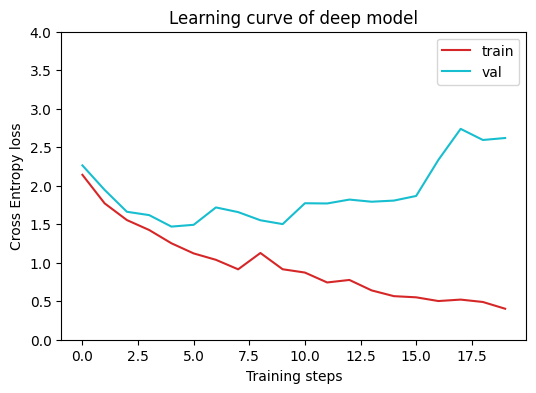

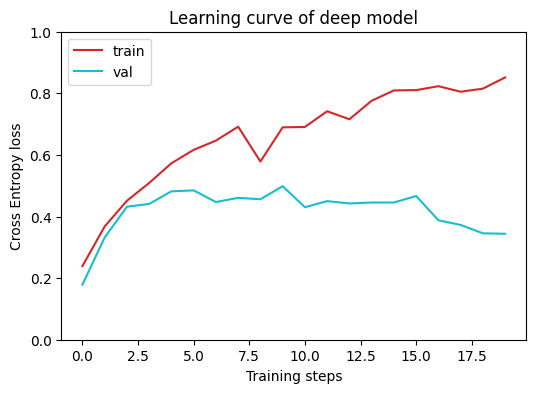

In [37]:
# save prediction and plotting
preds = test(test_loader, model, device)
save_pred(preds, 'pred.csv')
plot_learning_curve_loss(model_loss_record, title='deep model')
plot_learning_curve_acc(model_acc_record, title='deep model')